## 1.5 Simple LGBM Solution

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.06.28 </div> 
<div style="text-align: right"> Last update: 2022.06.28</div> 

- https://www.kaggle.com/code/ryches/simple-lgbm-solution/notebook

### 라이브러리 import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150

### Loading data

In [2]:
print(os.listdir('data/ashrae-energy-prediction/'))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'test_df.pkl', 'train.csv', 'train_df.pkl', 'weather_test.csv', 'weather_train.csv']


In [3]:
building_df = pd.read_csv('data/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('data/ashrae-energy-prediction/weather_train.csv')
train = pd.read_csv('data/ashrae-energy-prediction/train.csv')

유용한 피처들   
Buildings  
- primary_use
- square_feet
- year_built
- floor_count (may be too sparse to use)

Weather  
- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags   

Train  
- max, mean, min, std of the specific building historically
- number of meters
- number of buildings at a siteid

In [4]:
building_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [5]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [6]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [7]:
train = train.merge(building_df, left_on='building_id', right_on = 'building_id', how = 'left')

In [8]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


In [9]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [10]:
train = train.merge(weather_train, left_on = ['site_id', 'timestamp'], right_on = ['site_id', 'timestamp'],
                   how = 'left')

In [11]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [12]:
del weather_train

In [13]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekend"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

In [14]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


In [15]:
train.shape

(20216100, 20)

에러가 있는 리딩 살펴보기

<AxesSubplot:xlabel='timestamp'>

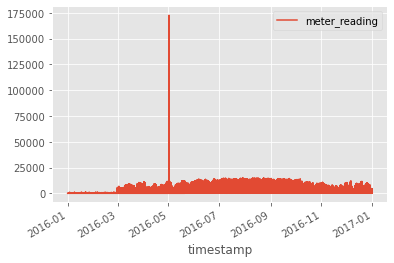

In [16]:
train[train["site_id"] == 0].plot("timestamp", "meter_reading")

<AxesSubplot:xlabel='timestamp'>

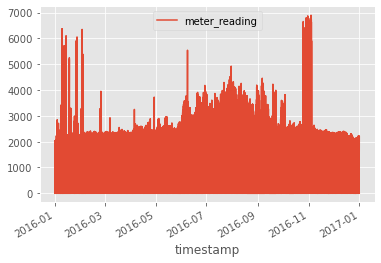

In [17]:
train[train["site_id"] == 2].plot("timestamp", "meter_reading")

In [18]:
train[["hour", "day", "weekend", "month"]]

,hour,day,weekend,month
0,0,1,4,1
1,0,1,4,1
2,0,1,4,1
3,0,1,4,1
4,0,1,4,1
...,...,...,...,...
20216095,23,31,5,12
20216096,23,31,5,12
20216097,23,31,5,12
20216098,23,31,5,12


불필요 컬럼 드롭

In [19]:
train = train.drop('timestamp', axis = 1)

인코딩

In [20]:
train.head(2)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])

In [22]:
categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

In [23]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekend,month
0,0,0,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
1,1,0,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
2,2,0,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
3,3,0,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1
4,4,0,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,4,1


컬럼 정리

In [24]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]
numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage", "dew_temperature"]
categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

In [25]:
train[categoricals + numericals]

,building_id,primary_use,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,1,4,1,0,7432,2008.0,25.0,6.0,20.0
1,1,0,0,1,4,1,0,2720,2004.0,25.0,6.0,20.0
2,2,0,0,1,4,1,0,5376,1991.0,25.0,6.0,20.0
3,3,0,0,1,4,1,0,23685,2002.0,25.0,6.0,20.0
4,4,0,0,1,4,1,0,116607,1975.0,25.0,6.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,1,23,31,5,12,0,19619,1914.0,1.7,NaN,-5.6
20216096,1445,0,23,31,5,12,0,4298,NaN,1.7,NaN,-5.6
20216097,1446,1,23,31,5,12,0,11265,1997.0,1.7,NaN,-5.6
20216098,1447,4,23,31,5,12,0,29775,2001.0,1.7,NaN,-5.6


In [26]:
feat_cols = categoricals + numericals

In [27]:
train["meter_reading"].value_counts()

0.0000      1873976
20.0000       23363
2.9307        23181
36.6000       22154
8.7921        21787
             ...   
27.8031           1
58.9751           1
90.4884           1
370.9390          1
55.6241           1
Name: meter_reading, Length: 1688175, dtype: int64

결측치 제거??

In [28]:
#maybe remove some of the high outliers because of sensor error
# train["meter_reading"] = train["meter_reading"].clip(upper = train["meter_reading"].quantile(.999)

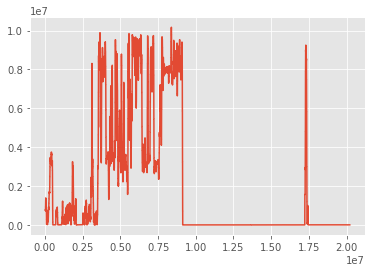

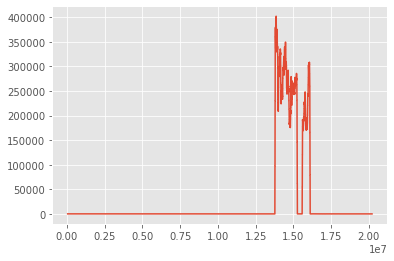

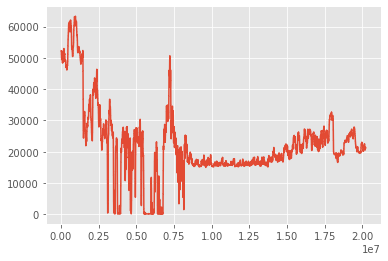

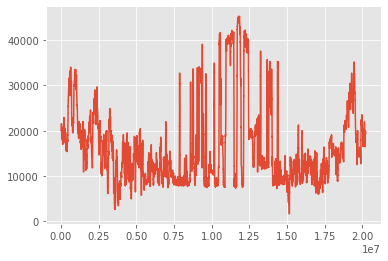

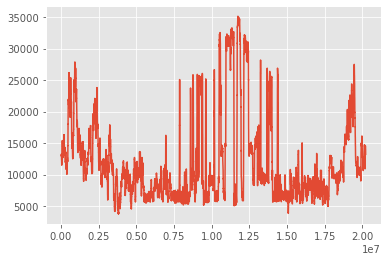

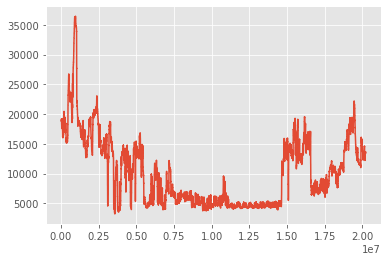

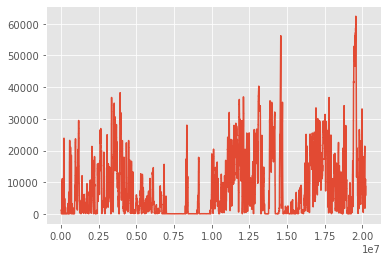

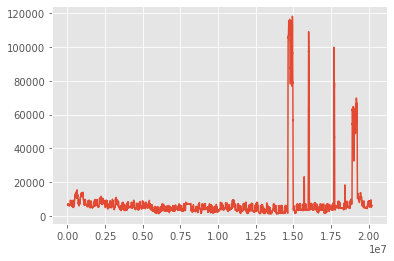

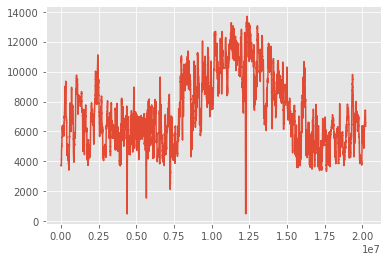

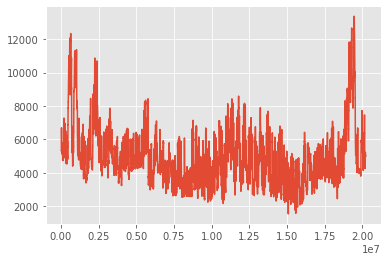

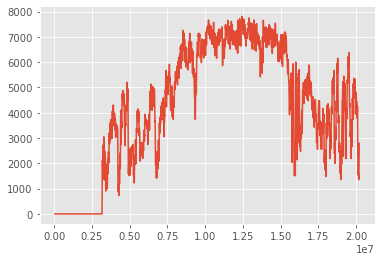

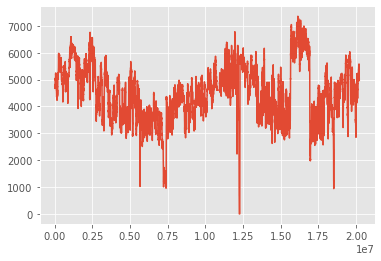

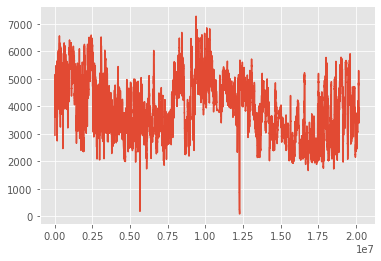

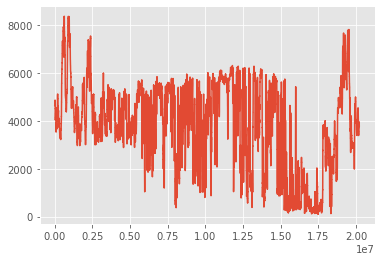

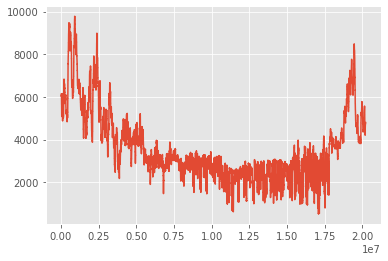

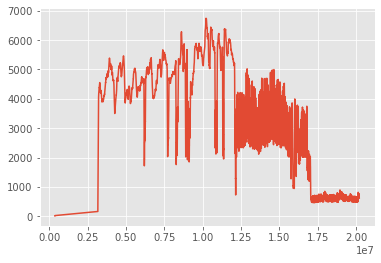

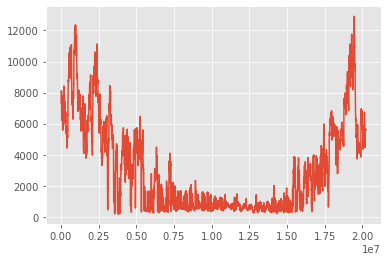

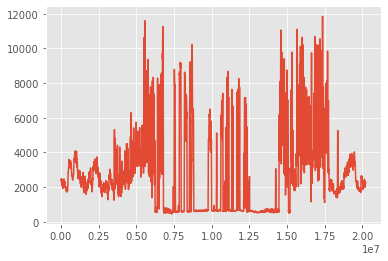

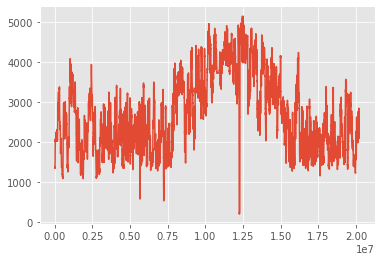

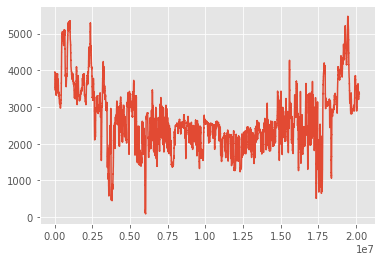

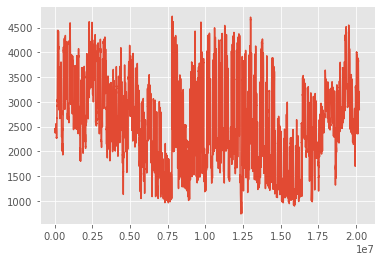

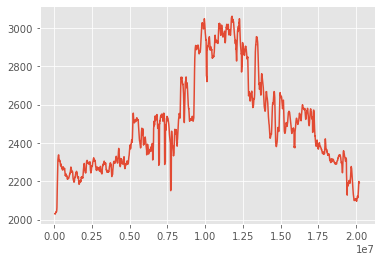

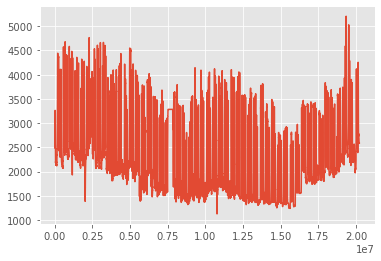

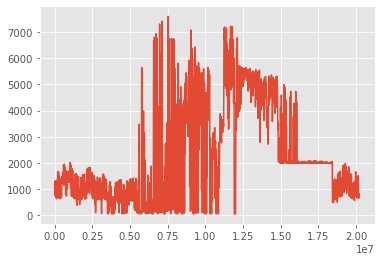

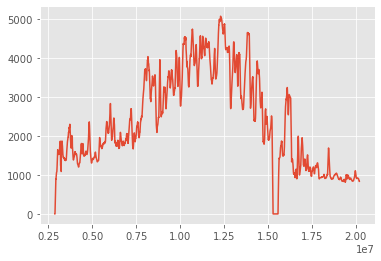

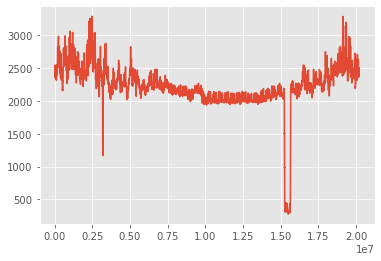

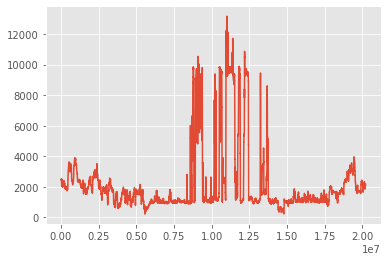

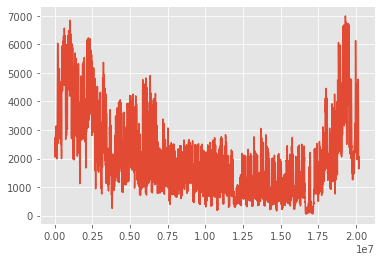

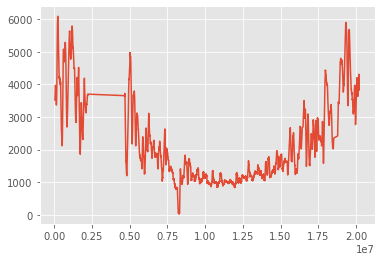

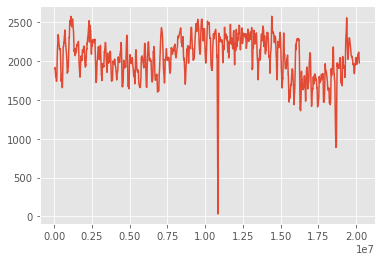

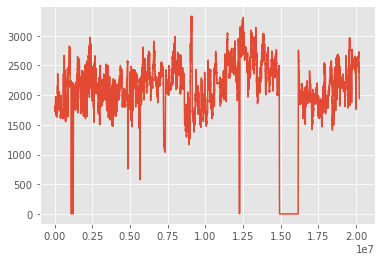

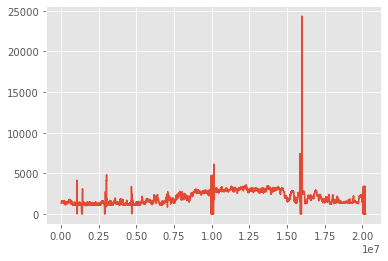

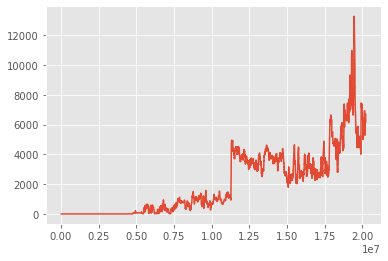

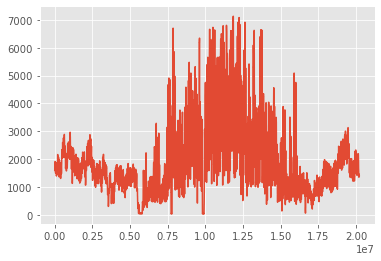

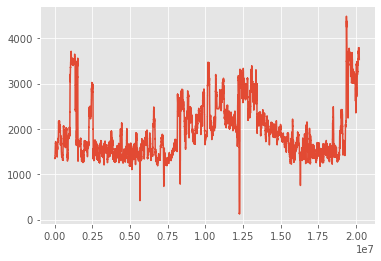

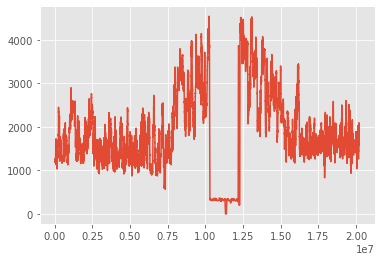

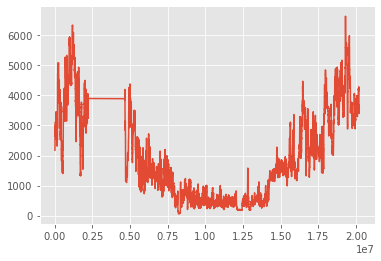

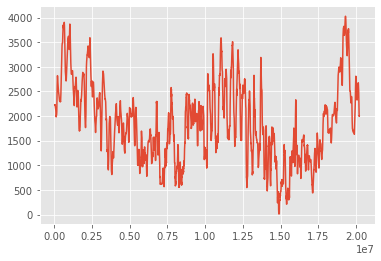

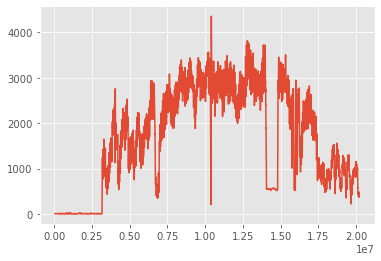

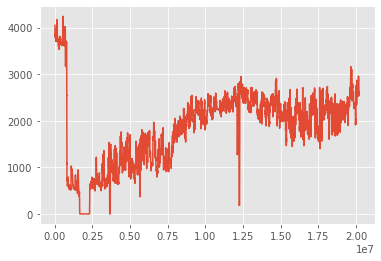

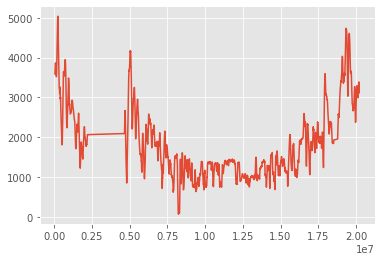

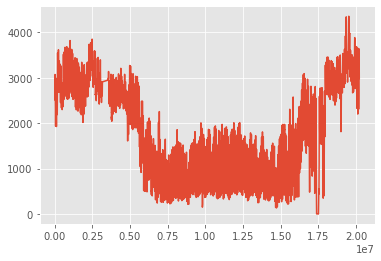

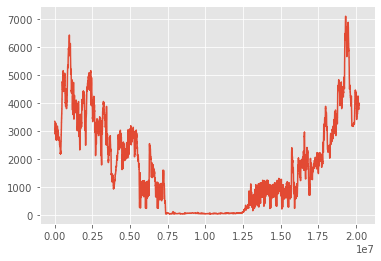

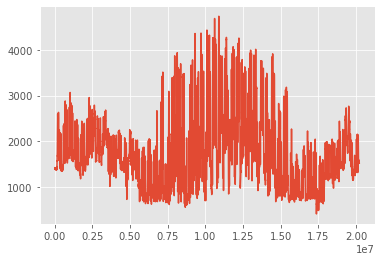

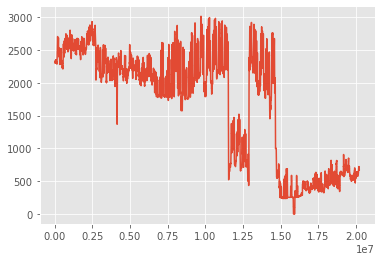

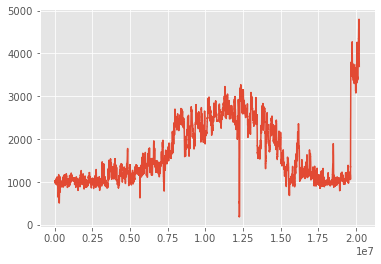

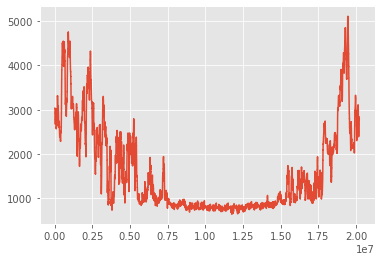

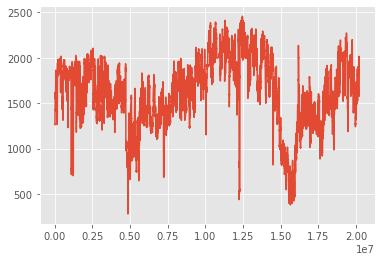

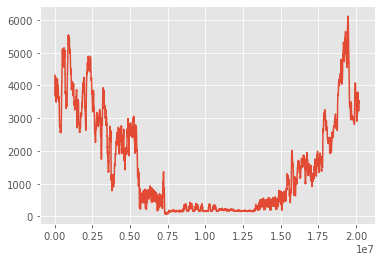

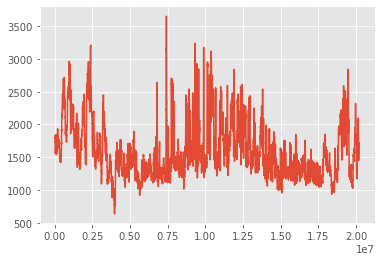

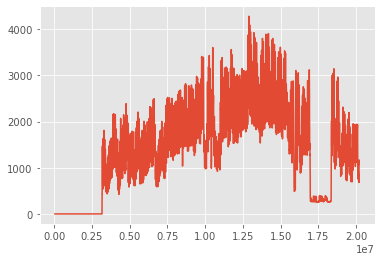

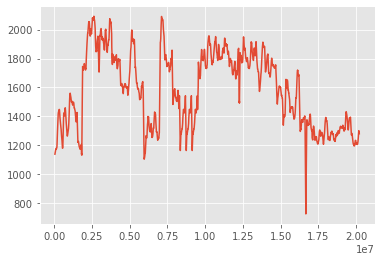

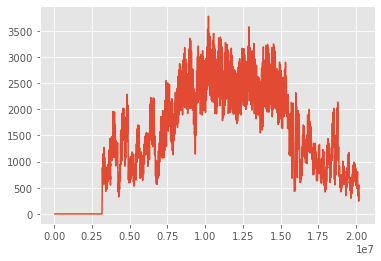

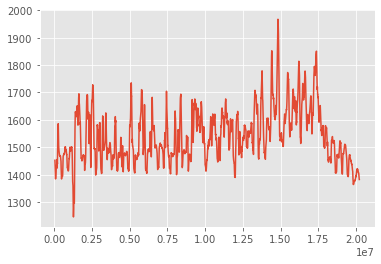

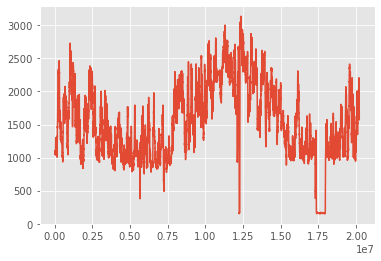

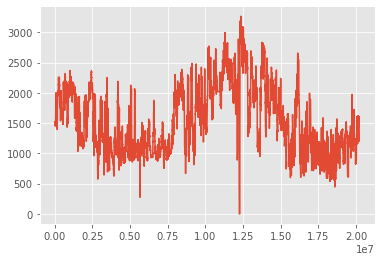

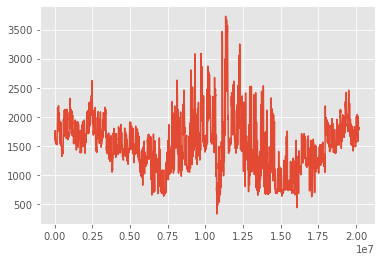

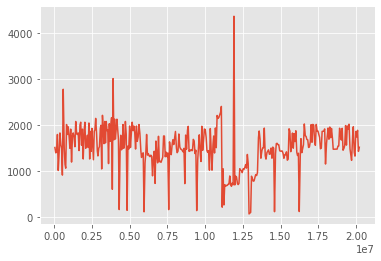

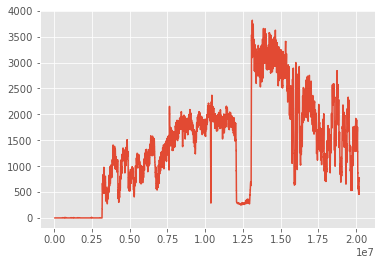

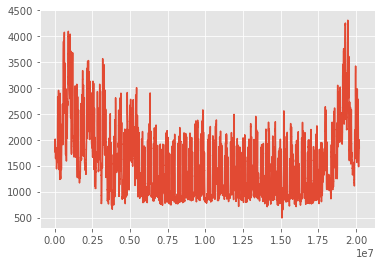

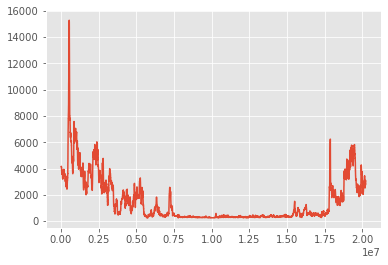

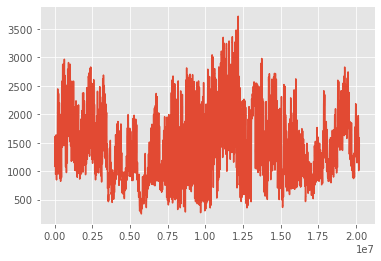

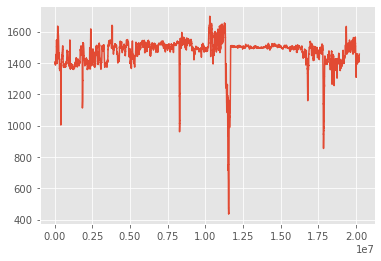

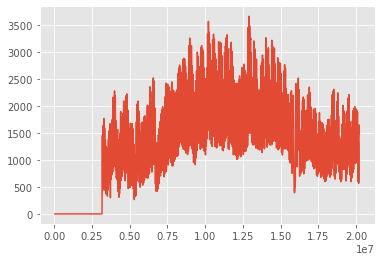

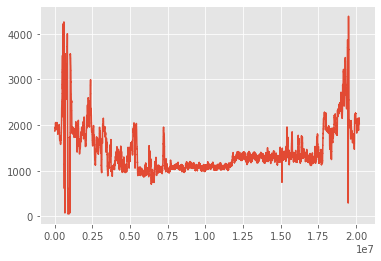

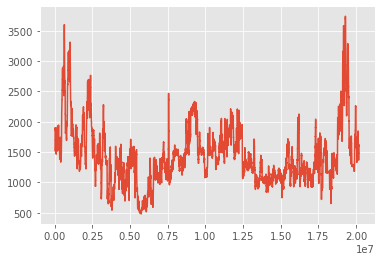

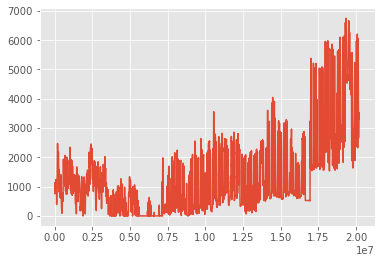

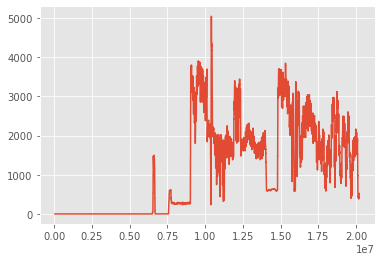

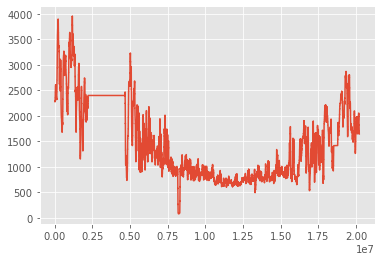

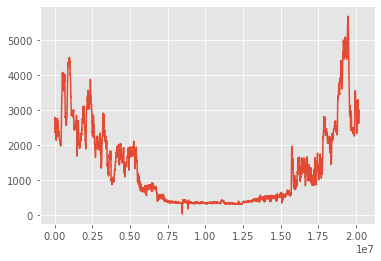

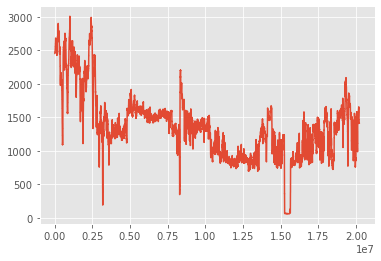

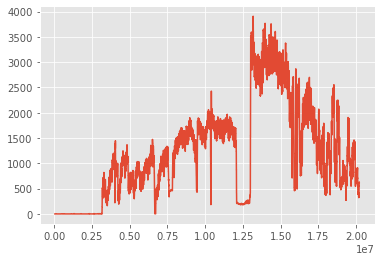

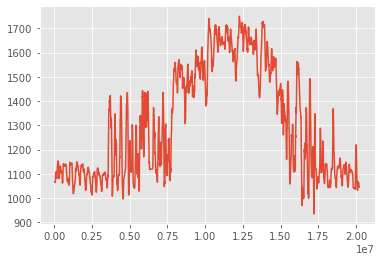

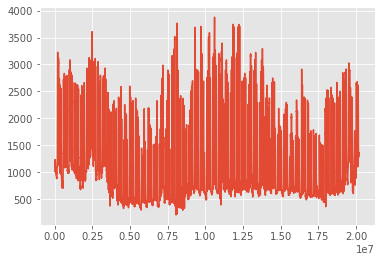

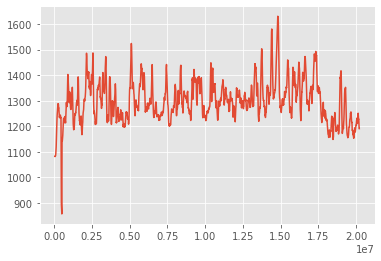

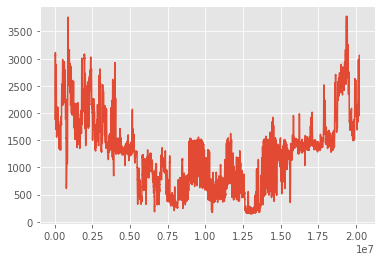

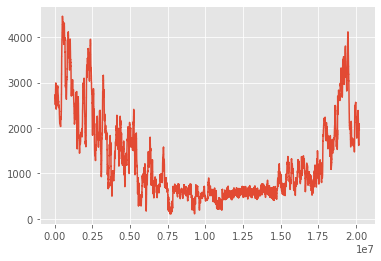

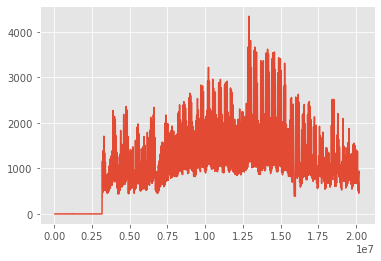

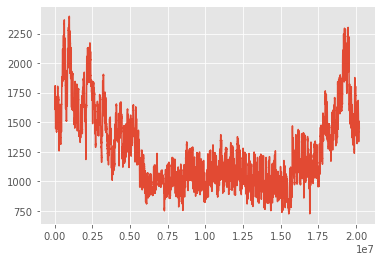

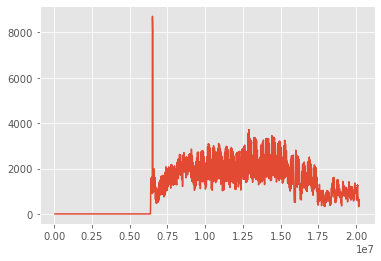

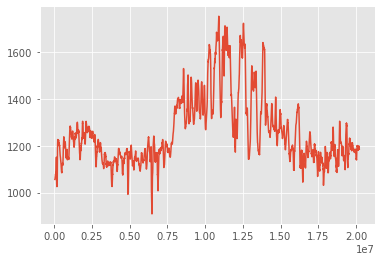

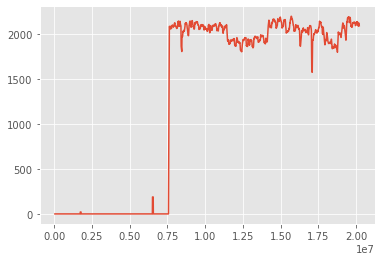

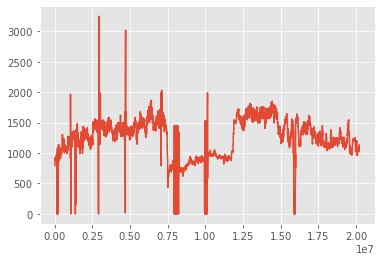

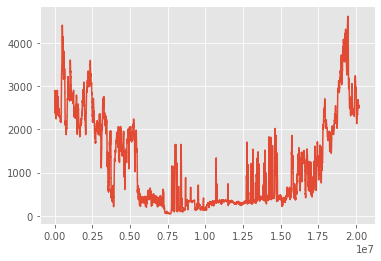

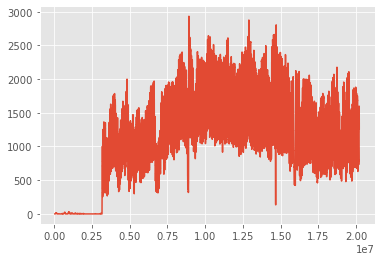

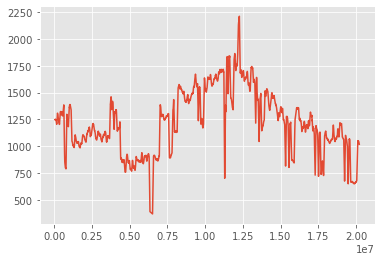

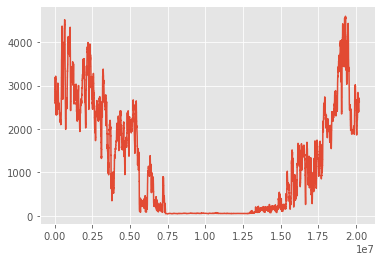

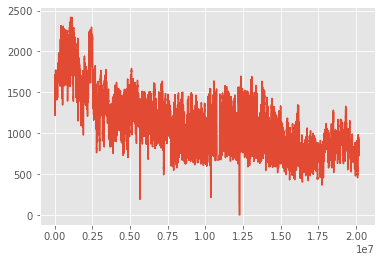

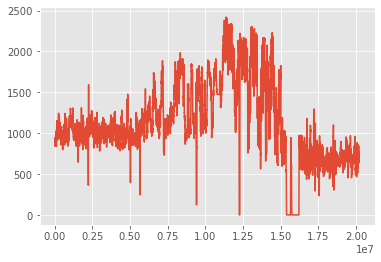

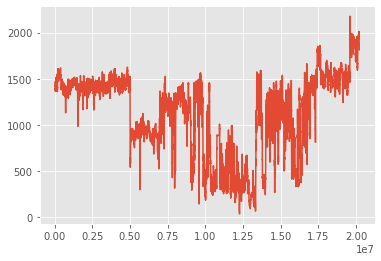

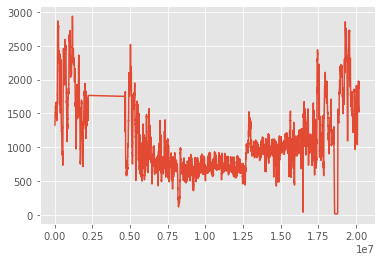

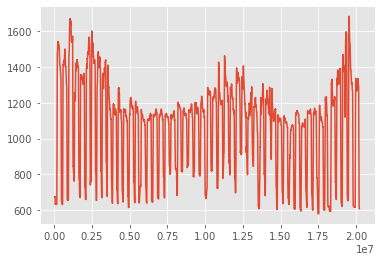

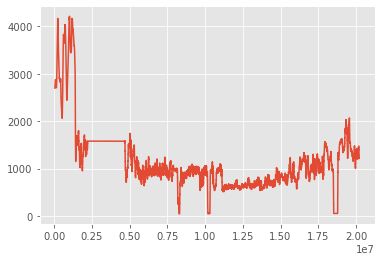

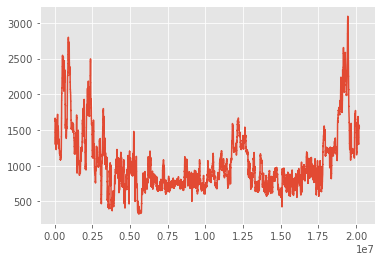

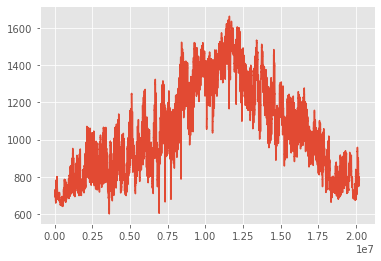

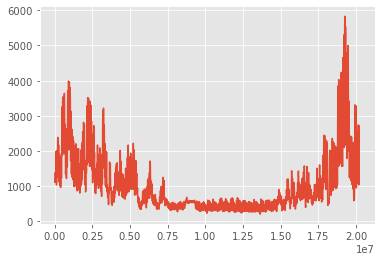

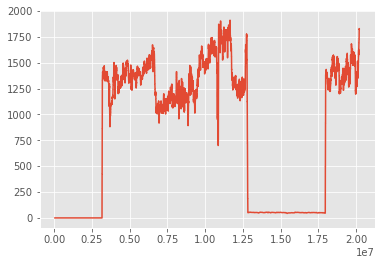

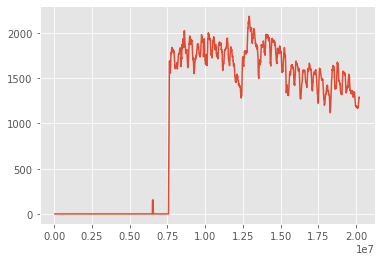

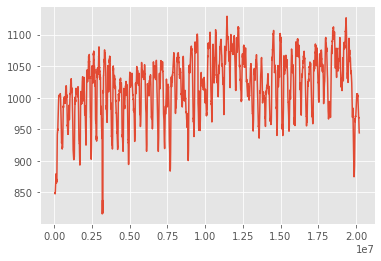

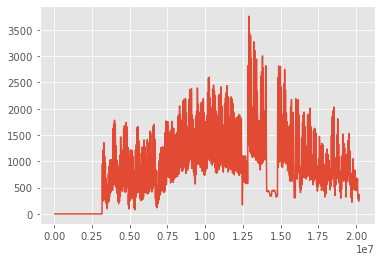

In [29]:
top_buildings = train.groupby("building_id")["meter_reading"].mean().sort_values(ascending = False).iloc[:100]
for value in top_buildings.index:
    train[train["building_id"] == value]["meter_reading"].rolling(window = 24).mean().plot()
    plt.show()

In [30]:
target = np.log1p(train["meter_reading"])

In [31]:
del train['meter_reading']

In [32]:
train = train.drop(drop_cols + ["site_id", "floor_count"], axis = 1)

In [33]:
train

,building_id,meter,primary_use,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,hour,day,weekend,month
0,0,0,0,7432,2008.0,25.0,6.0,20.0,0,1,4,1
1,1,0,0,2720,2004.0,25.0,6.0,20.0,0,1,4,1
2,2,0,0,5376,1991.0,25.0,6.0,20.0,0,1,4,1
3,3,0,0,23685,2002.0,25.0,6.0,20.0,0,1,4,1
4,4,0,0,116607,1975.0,25.0,6.0,20.0,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,1,19619,1914.0,1.7,NaN,-5.6,23,31,5,12
20216096,1445,0,0,4298,NaN,1.7,NaN,-5.6,23,31,5,12
20216097,1446,0,1,11265,1997.0,1.7,NaN,-5.6,23,31,5,12
20216098,1447,0,4,29775,2001.0,1.7,NaN,-5.6,23,31,5,12


In [34]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [35]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 1927.957534790039  MB
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int32
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for this col:  875000
dtype after:  uint32
******************************
******************************
Column:  year_built
dtype before:  float64
min for this col:  1900.0
max for this col:  2017.0
dtype after:  uint16
******************************
******************************
Column:  air_temperature
dtype before:  float64
min for 

학습

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [38]:
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = False)
error = 0
models = []

(중요) 개념 :  
    - reading에 0이하의 값이 많다.  
    - reading이 0이하일지 아닐지 예측하는 분류모델과 reading을 예측하는 회귀모델 두개를 만든다.  
    - 그리고 최종 예측을 할 때는 0이하로 값은 0으로 대체하도록 만든다.  

In [40]:
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
        
    print(train_index.max(), val_index.min())
    
    X_train = train[feat_cols].iloc[train_index]
    X_val = train[feat_cols].iloc[train_index]
    y_train = target.iloc[train_index]
    y_val = target.iloc[train_index]
    
    lgb_train = lgb.Dataset(X_train, y_train > 0)
    lgb_eval = lgb.Dataset(X_val, y_val > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    lgb_train = lgb.Dataset(X_train[y_train > 0], y_train[y_train > 0]) # reading이 0이하인 데이터 제거
    lgb_eval = lgb.Dataset(X_val[y_val > 0] , y_val[y_val > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    y_pred = (gbm_class.predict(X_val, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(X_val, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (y_val)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (y_val))))
    break
print(error)

16172879 16172880
[LightGBM] [Info] Number of positive: 14588424, number of negative: 1584456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 16172880, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.902030 -> initscore=2.219987
[LightGBM] [Info] Start training from score 2.219987
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.180057	valid_1's binary_logloss: 0.180057
[40]	training's binary_logloss: 0.157386	valid_1's binary_logloss: 0.157386
[60]	training's binary_logloss: 0.145311	valid_1's binary_logloss: 0.145311
[80]	training's binary_logloss: 0.136799	valid_1's binary_logloss: 0.136799
[100]	training's binary_logloss: 0.130444	valid_1'

[960]	training's rmse: 0.402207	valid_1's rmse: 0.402207
[980]	training's rmse: 0.400691	valid_1's rmse: 0.400691
[1000]	training's rmse: 0.399605	valid_1's rmse: 0.399605
[1020]	training's rmse: 0.39793	valid_1's rmse: 0.39793
[1040]	training's rmse: 0.396723	valid_1's rmse: 0.396723
[1060]	training's rmse: 0.395243	valid_1's rmse: 0.395243
[1080]	training's rmse: 0.393945	valid_1's rmse: 0.393945
[1100]	training's rmse: 0.392947	valid_1's rmse: 0.392947
[1120]	training's rmse: 0.391582	valid_1's rmse: 0.391582
[1140]	training's rmse: 0.390419	valid_1's rmse: 0.390419
[1160]	training's rmse: 0.38944	valid_1's rmse: 0.38944
[1180]	training's rmse: 0.388366	valid_1's rmse: 0.388366
[1200]	training's rmse: 0.387272	valid_1's rmse: 0.387272
[1220]	training's rmse: 0.386186	valid_1's rmse: 0.386186
[1240]	training's rmse: 0.384979	valid_1's rmse: 0.384979
[1260]	training's rmse: 0.384069	valid_1's rmse: 0.384069
[1280]	training's rmse: 0.38263	valid_1's rmse: 0.38263
[1300]	training's rmse

In [41]:
sorted(zip(gbm_regress.feature_importance(), gbm_regress.feature_name()),reverse = True)

[(10689, 'building_id'),
 (9591, 'square_feet'),
 (6025, 'month'),
 (5889, 'hour'),
 (5079, 'meter'),
 (4737, 'air_temperature'),
 (4017, 'day'),
 (3626, 'primary_use'),
 (3610, 'dew_temperature'),
 (3467, 'year_built'),
 (2676, 'weekend'),
 (594, 'cloud_coverage')]

In [43]:
import gc
del train

NameError: name 'train' is not defined

In [44]:
del X_train, X_val, lgb_train, lgb_eval, y_train, y_val, y_pred, target

In [45]:
gc.collect()

221242

예측하기

In [46]:
test = pd.read_csv("data/ashrae-energy-prediction/test.csv")
# test, NAlist = reduce_mem_usage(test)
test = test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
del building_df
gc.collect()

173

In [47]:
test["primary_use"] = le.transform(test["primary_use"])

In [48]:
test, NAlist = reduce_mem_usage(test)

Memory usage of properties dataframe is : 3022.210693359375  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int64
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int32
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  int64
min for this col:  283
max for thi

In [49]:
test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,0,7432,2008,0
1,1,1,0,2017-01-01 00:00:00,0,0,2720,2004,0
2,2,2,0,2017-01-01 00:00:00,0,0,5376,1991,0
3,3,3,0,2017-01-01 00:00:00,0,0,23685,2002,0
4,4,4,0,2017-01-01 00:00:00,0,0,116607,1975,0
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,1,19619,1914,0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,0,4298,1899,0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,1,11265,1997,0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,4,29775,2001,0


In [50]:
weather_test = pd.read_csv("data/ashrae-energy-prediction/weather_test.csv")
weather_test = weather_test.drop(drop_cols, axis = 1)

In [51]:
weather_test

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature
0,0,2017-01-01 00:00:00,17.8,4.0,11.7
1,0,2017-01-01 01:00:00,17.8,2.0,12.8
2,0,2017-01-01 02:00:00,16.1,0.0,12.8
3,0,2017-01-01 03:00:00,17.2,0.0,13.3
4,0,2017-01-01 04:00:00,16.7,2.0,13.3
...,...,...,...,...,...
277238,15,2018-12-31 19:00:00,3.3,NaN,1.7
277239,15,2018-12-31 20:00:00,2.8,NaN,1.1
277240,15,2018-12-31 21:00:00,2.8,NaN,1.7
277241,15,2018-12-31 22:00:00,2.8,NaN,2.2


In [52]:
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")
del weather_test

In [53]:
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["hour"] = test["timestamp"].dt.hour.astype(np.uint8)
test["day"] = test["timestamp"].dt.day.astype(np.uint8)
test["weekend"] = test["timestamp"].dt.weekday.astype(np.uint8)
test["month"] = test["timestamp"].dt.month.astype(np.uint8)
test = test[feat_cols]

In [54]:
from tqdm import tqdm
i=0
res=[]
step_size = 50000

In [55]:
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    
    res.append(np.expm1((gbm_class.predict(test.iloc[i:i+step_size], num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(test.iloc[i:i+step_size], num_iteration=gbm_regress.best_iteration))))
    i+=step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [07:10<00:00,  1.94it/s]


In [56]:
del test

In [57]:
res

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.        ,  0.        ,  0.        , ..., 62.23695023,
         0.        ,  0.        ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([845.50510739,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]),
 array([   0.        ,    0.        ,    0.        , ..., 1326.53691549,
           0.        ,    0.        ]),
 array([  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 276.55940775]),
 array([  0.        ,   0.        ,   0.        , ..., 165.4943756 ,
        367.58707459, 373.62422666]),
 array([ 308.82459912,  298.61649673, 1313.18792011, ...,   17.87930784,
         140.49362584,   88.9331742 ]),
 array([ 146.34158283,   85.59550825, 1029.60962753, ...,  405.63903785,
          97.20631076,  893.39076795]),
 array([5208.00051932,  314.78593682,  575.02038778, ..., 4029.57686975,
         2

In [61]:
len(res)

41697600

In [58]:
res = np.concatenate(res)

In [60]:
res.shape

(41697600,)

In [62]:
sub = pd.read_csv('data/ashrae-energy-prediction/sample_submission.csv')

In [63]:
sub['meter_reading'] = res

sub.to_csv('data/ashrae-energy-prediction/submission.csv')